In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Mon Aug 28 15:48:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   43C    P0    67W / 275W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [3]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [4]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [5]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[13:11:32.668] INFO   CaloQVAE                                          Willkommen!
[13:11:32.669] INFO   CaloQVAE                                          Loading configuration.


In [6]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)

[13:11:33.158] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[13:11:33.159] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[13:11:33.159] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2023-08-24 13:11:33,654 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[13:11:33.654] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [7]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [8]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[13:11:34.949] INFO   data.dataManager                                  Loading Data
[13:11:39.890] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa9b19f1e90>: 96184 events, 752 batches
[13:11:39.892] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa9b19fc250>: 12023 events, 12 batches
[13:11:39.892] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa9b1a42390>: 12023 events, 12 batches
[13:11:41.598] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNN
2023-08-24 13:11:41

Initializing NetworkV3
Initializing NetworkV3


In [9]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[13:11:44.464] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 533])
[13:11:44.464] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[13:11:45.102] INFO   engine.engineAtlas                                Setting up engine Atlas.
[13:11:45.102] INFO   engine.engineCaloV3                               Setting up engine Calo.
[13:11:45.102] INFO   engine.engine                                     Setting up default engine.


In [10]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[13:11:49.735] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa873f00f90>: 96184 events, 752 batches
[13:11:49.736] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa8224aa390>: 12023 events, 12 batches
[13:11:49.736] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa8786a5910>: 12023 events, 12 batches


In [11]:
###LOAD MODEL

In [12]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [46]:

# generous-wave-3
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
modelname = 'generous-wave-3'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # faithful-sunset-4
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'faithful-sunset-4'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# lemon-water-5
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'lemon-water-5'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # atomic-glitter-6
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'atomic-glitter-6'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False


# fearless-plasma-9
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'fearless-plasma-9'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False

    
# flowing-serenity-11
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'fearless-plasma-9'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# vocal-lake-17
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'vocal-lake-17'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# clean-pyramid-18
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
modelname = 'clean-pyramid-18'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasCRBMCNN
pion1
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder
Loading weights for module =  classifier
Loading weights for module =  sampler


In [56]:
### xx = next(iter(train_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([759, 533])


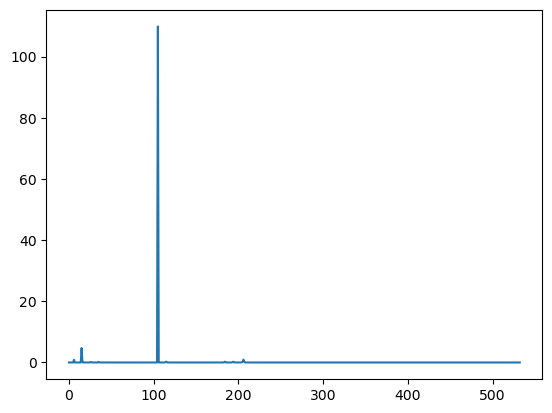

In [57]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[2,:])

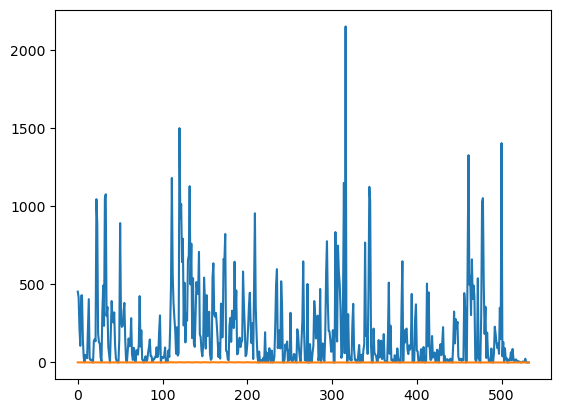

In [58]:
with torch.no_grad():
    fwd_output = engine.model((in_data, true_energy), True)
idx = 20
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:])

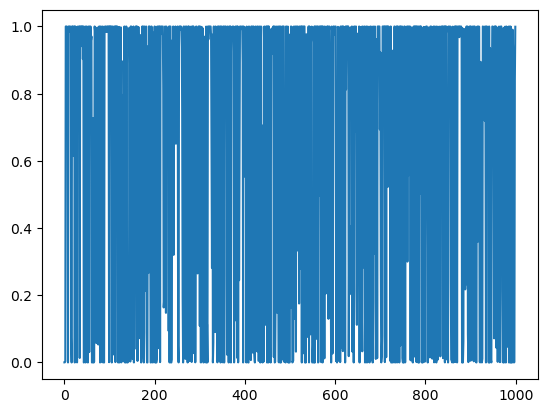

In [59]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

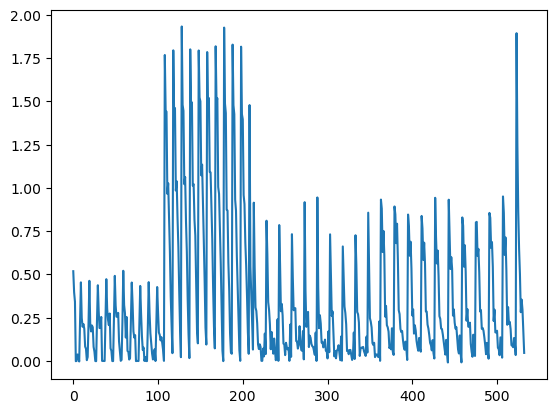

In [60]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


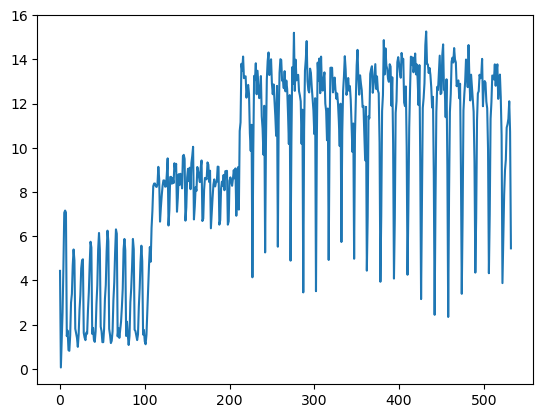

In [64]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [95]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

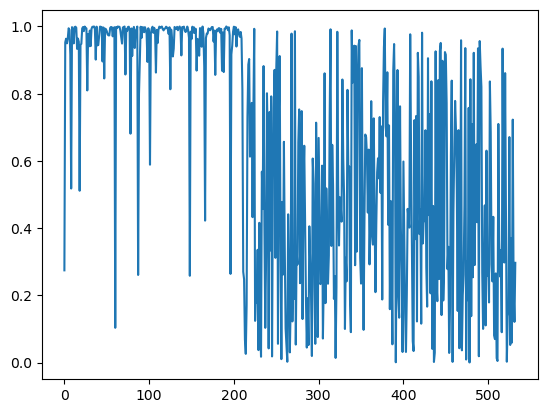

In [96]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [20]:
# for i in range(1,100):
#     print(533 % i, i, 533/i)

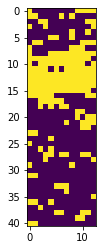

In [30]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
# plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(41,13))

In [44]:
nn.MSELoss()(fwd_output.output_activations, in_data)

tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)

In [65]:
# sample_energies

In [47]:
en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []

labelstarget_samples = []
labelsrecon_samples = []
for xx in val_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if reducedata:
        in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), False)
    if reducedata:
        in_data = engine._reduceinv(in_data, true_energy, R=R)
        recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
        sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
        sample_data = engine._reduceinv(sample_data, sample_energies, R=R)

    # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    
    xtarget_samples.append(in_data.detach().cpu())
    xrecon_samples.append( recon_data.detach().cpu())
    xgen_samples.append( sample_data.detach().cpu())
    
    # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )
    
    en_labels.append(true_energy.detach().cpu())
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)

labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
en_labels = torch.cat(en_labels, dim=0)

lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
l = torch.argmax(labelstarget_samples, dim=1).numpy()


In [48]:
(l == lhat).sum() / l.shape[0]

0.7906512517674458

In [49]:

# (xrecon_samples.sum(dim=1) == 0)[0].item()
for i, iszero in enumerate(xrecon_samples.sum(dim=0) == 0):
    if iszero:
        print(i)
        
for i, iszero in enumerate(xgen_samples.sum(dim=0) == 0):
    if iszero:
        print(i)

442
458
442
458


In [49]:
# idx = 442
# plt.hist(xtarget_samples[:,idx], bins=50, log=True, histtype='step')
# plt.show()

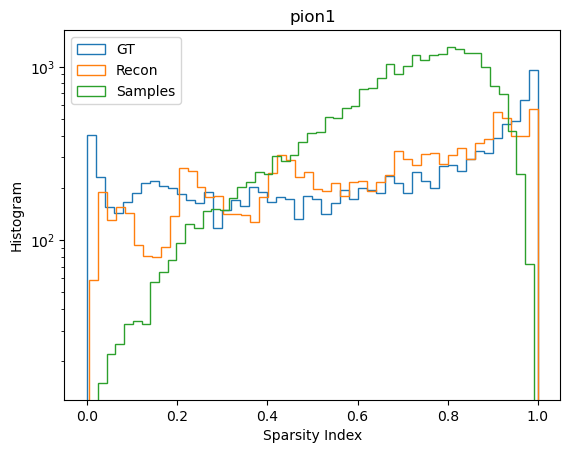

In [50]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/533).numpy(), bins=50, log=True, histtype='step')
plt.hist(((xrecon_samples == 0).sum(dim=1)/533).numpy(), bins=50, log=True, histtype='step')
plt.hist(((xgen_samples == 0).sum(dim=1)/533).numpy(), bins=50, log=True, histtype='step')
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

Layer  0 8  voxels


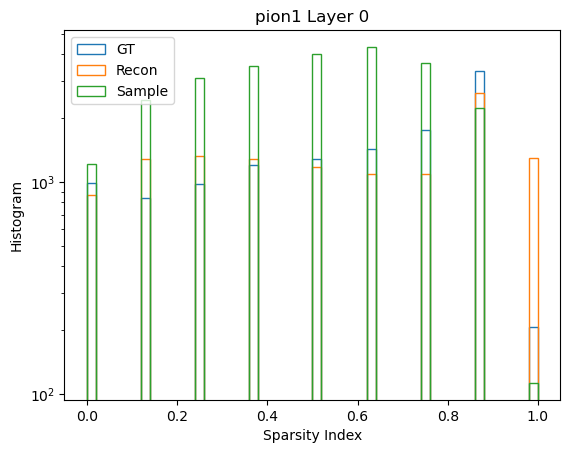

Layer  1 100  voxels


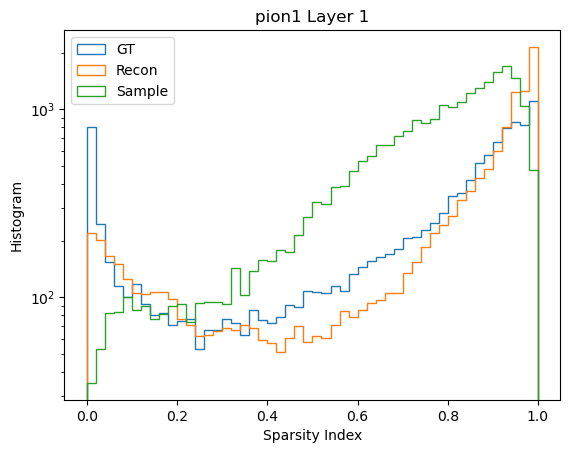

Layer  2 100  voxels


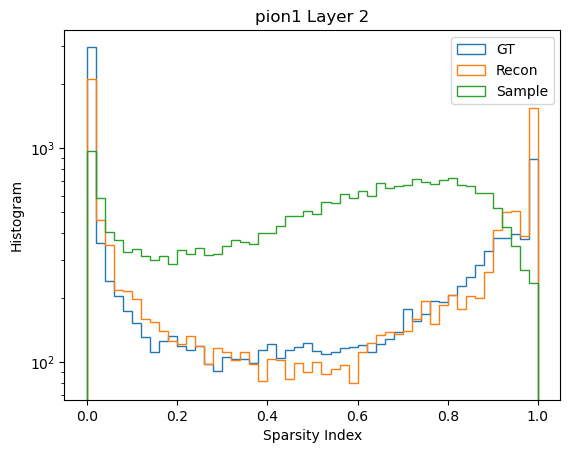

Layer  3 5  voxels


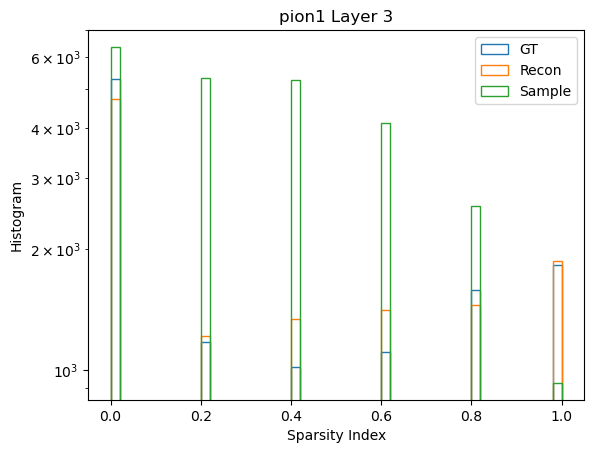

Layer  4 150  voxels


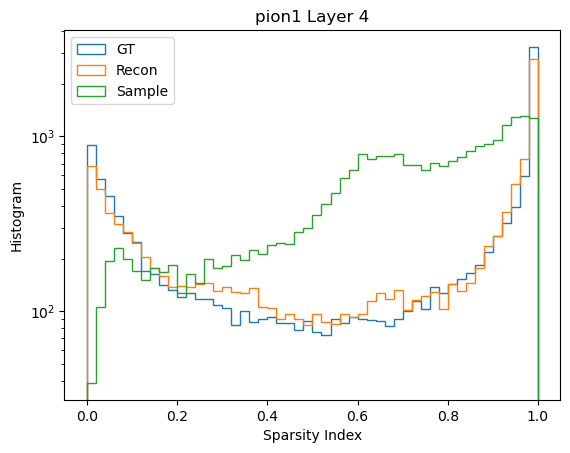

Layer  5 160  voxels


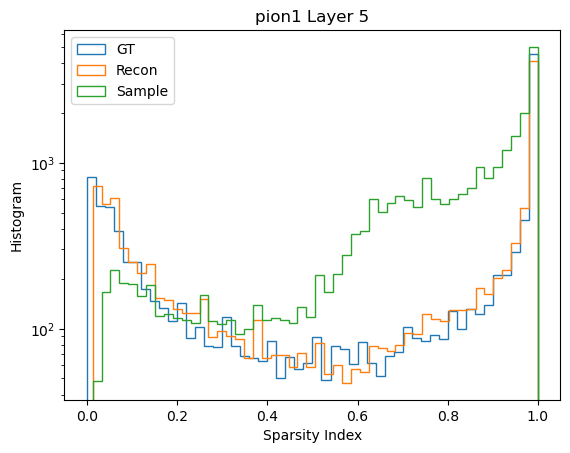

Layer  6 10  voxels


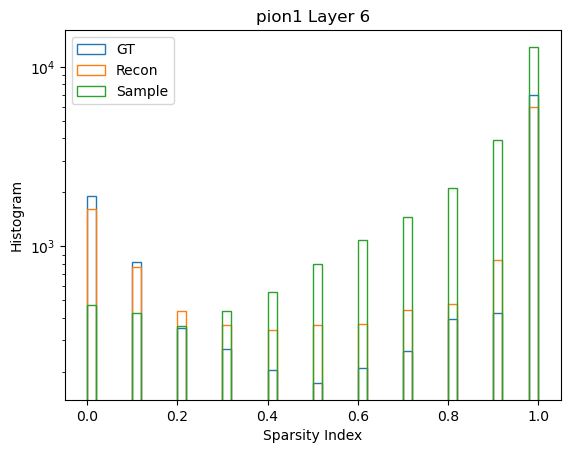

In [51]:
idxPrev = 0
for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step')
    plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step')
    plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=50, log=True, histtype='step')
    plt.xlabel("Sparsity Index")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part} Layer {i}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

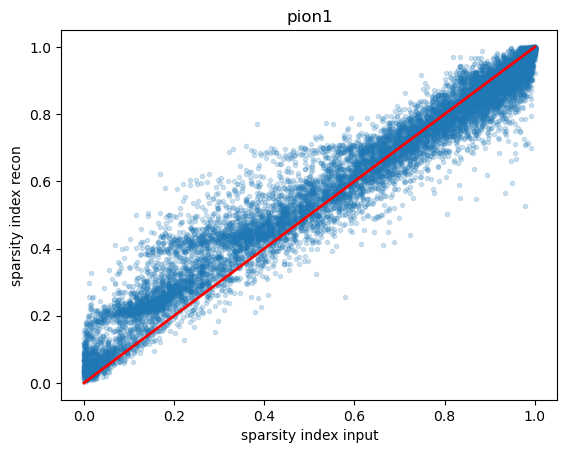

In [52]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/533).numpy(), ((xrecon_samples == 0).sum(dim=1)/533).numpy(),  marker='.', alpha=.2)
plt.plot([0,1],[0,1], c='red', lw=2)
plt.xlabel('sparsity index input')
plt.ylabel('sparsity index recon')
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

Layer  0 8  voxels


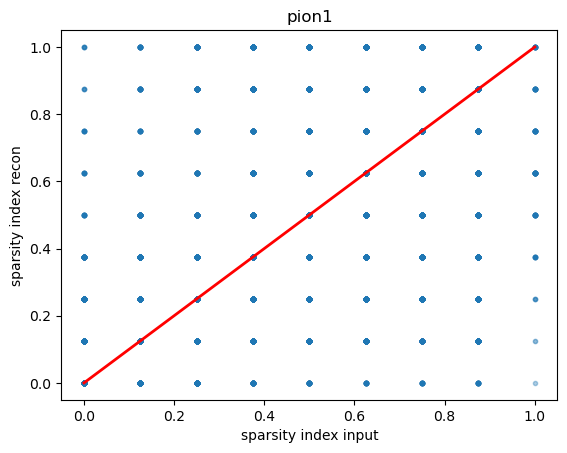

Layer  1 100  voxels


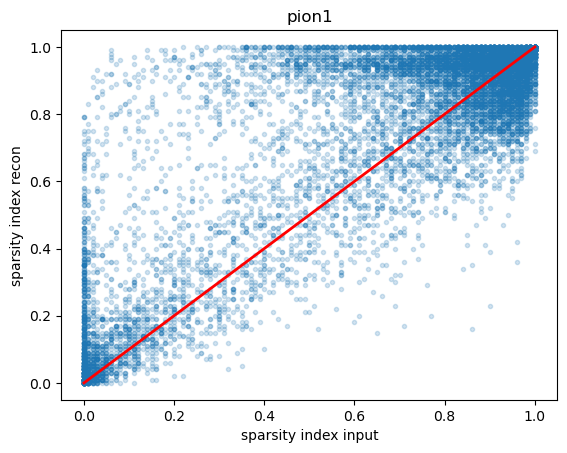

Layer  2 100  voxels


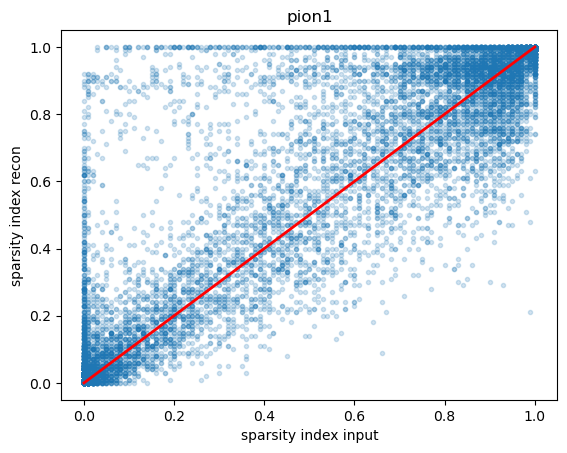

Layer  3 5  voxels


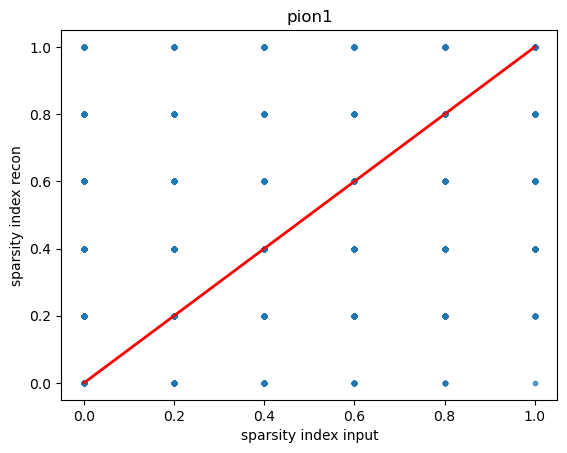

Layer  4 150  voxels


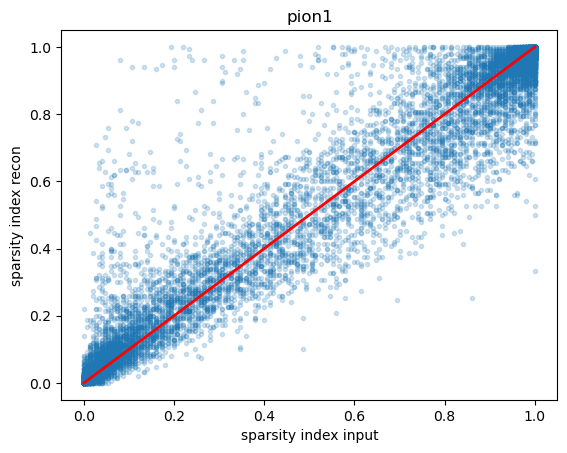

Layer  5 160  voxels


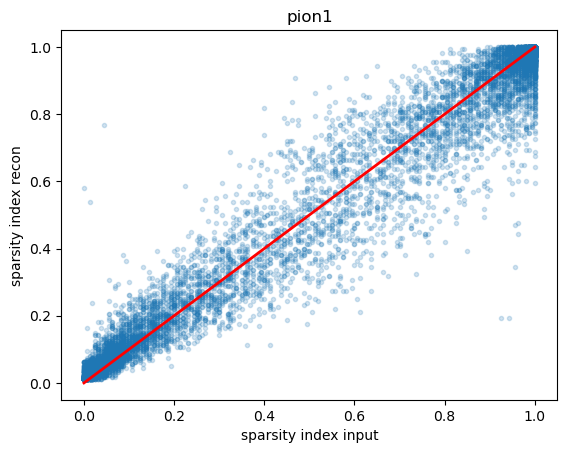

Layer  6 10  voxels


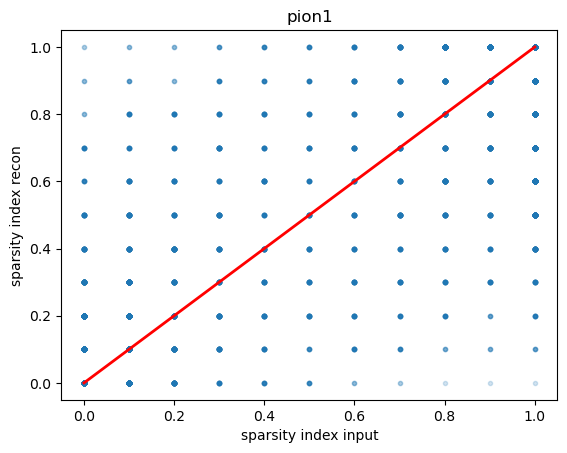

In [53]:
idxPrev = 0
for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
    plt.plot([0,1],[0,1], c='red', lw=2)
    plt.xlabel('sparsity index input')
    plt.ylabel('sparsity index recon')
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [401]:
# xihat_samples.shape
np.unique(HLF_1_photons.bin_edges)

array([  0,   8, 168, 358, 363, 368])

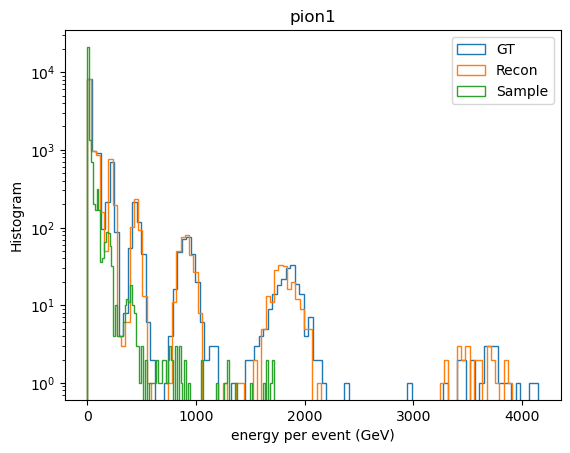

In [54]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=100, log=True, histtype='step')
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=100, log=True, histtype='step')
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=100, log=True, histtype='step')
plt.xlabel("energy per event (GeV)")

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample"])
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

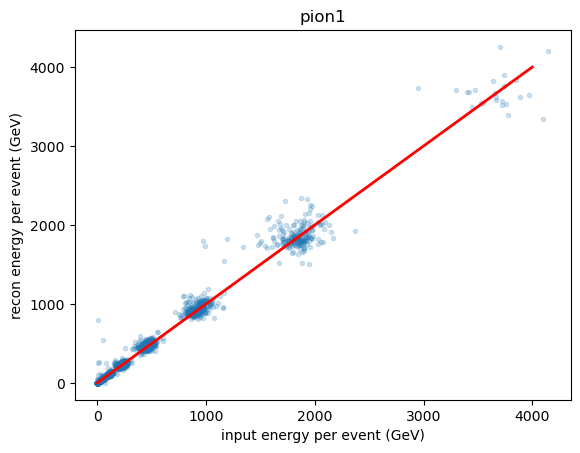

In [45]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.2)
plt.plot([0,4000],[0,4000], c='red', lw=2)

# sample_data_test = (sam.exp() - 1)*0.04*256*torch.pow(torch.tensor([2]),0)
# plt.hist(np.log(sample_data_test.sum(dim=1).numpy() + 1e-10), bins=10, density=False, alpha=0.7)
plt.xlabel("input energy per event (GeV)")
plt.ylabel("recon energy per event (GeV)")
plt.title(f'{part}')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [358]:
# plt.hist(xitarget_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xirecon_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.hist(xihat_samples.sum(dim=1).numpy(), bins=50, log=True, histtype='step')
# plt.xlabel("ξ per event")
# plt.ylabel("PDF")
# plt.legend(["GT", "Recon", "Sample"])
# plt.title("Pions")
# plt.show()

Layer  0 8  voxels


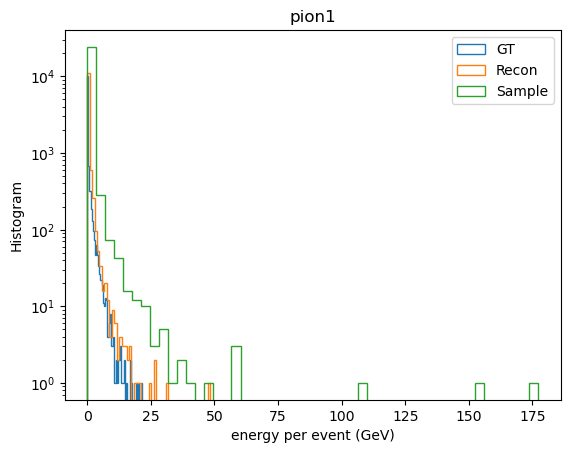

Layer  1 100  voxels


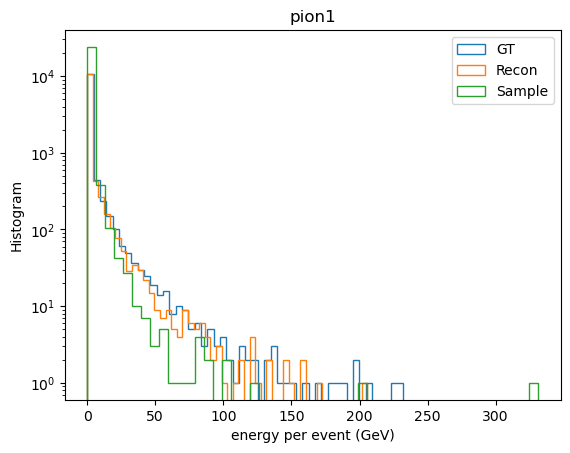

Layer  2 100  voxels


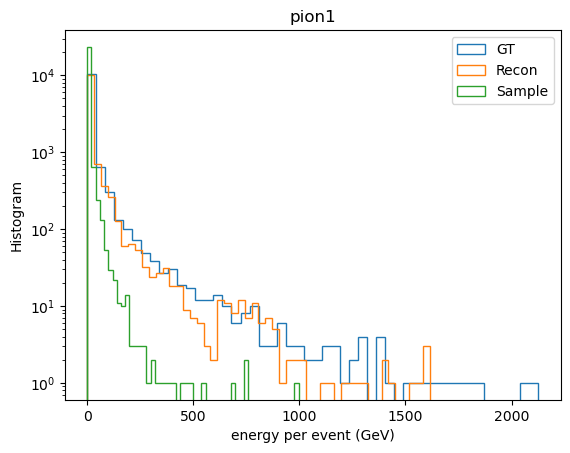

Layer  3 5  voxels


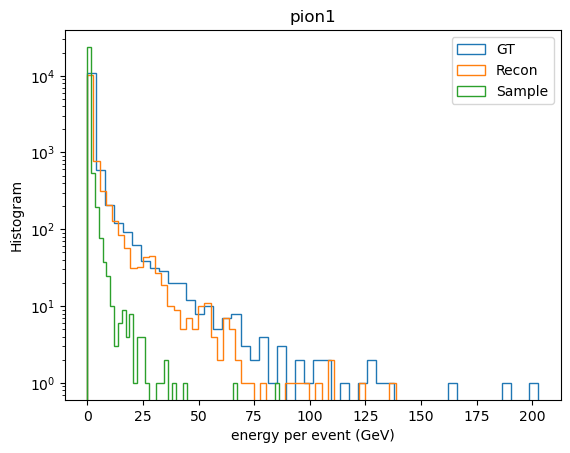

Layer  4 150  voxels


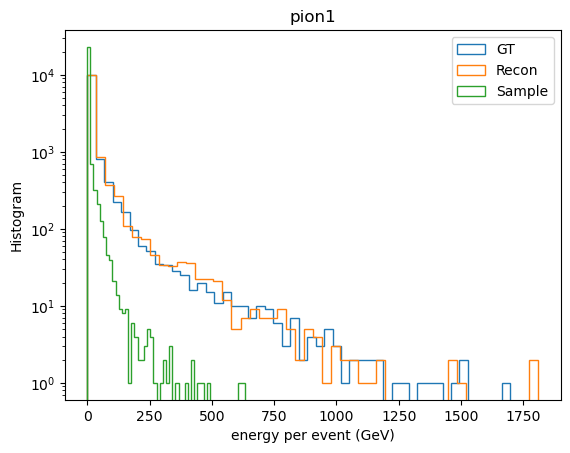

Layer  5 160  voxels


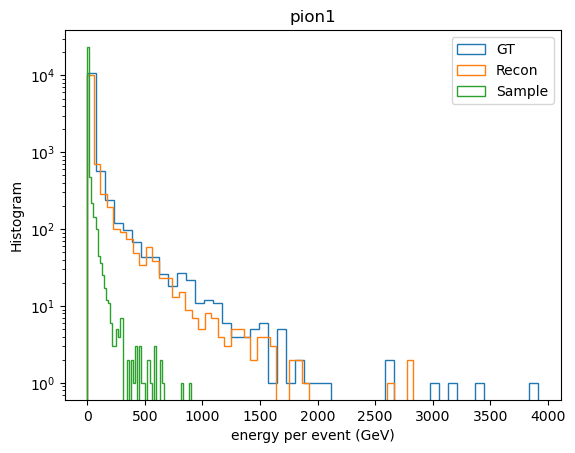

Layer  6 10  voxels


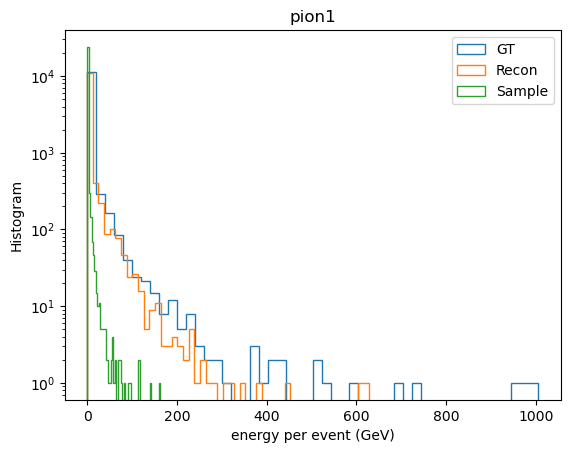

In [55]:
idxPrev = 0
for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=50, log=True, histtype='step')
    plt.xlabel("energy per event (GeV)")
    plt.ylabel("Histogram")
    plt.legend(["GT", "Recon", "Sample"])
    plt.title(f'{part}')
    # # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

Layer  0 8  voxels


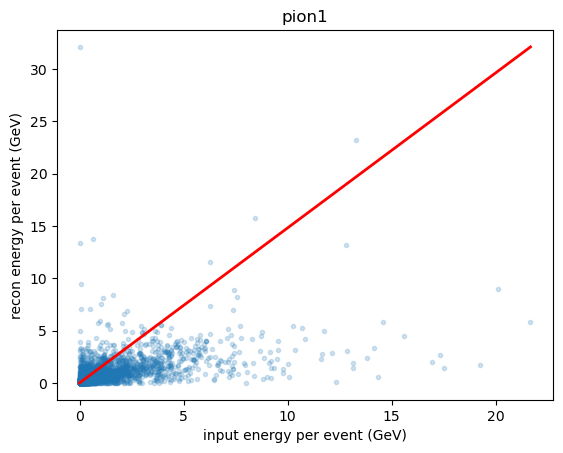

Layer  1 100  voxels


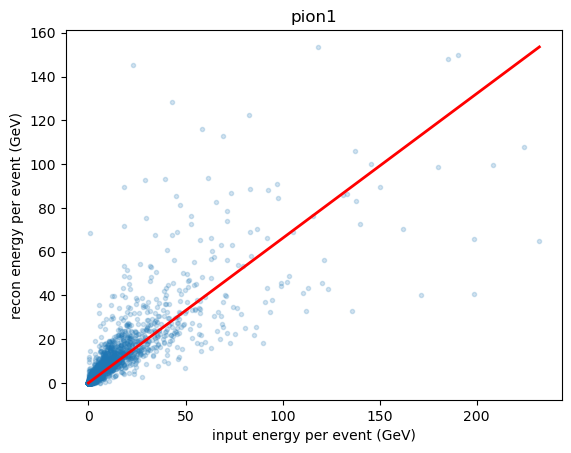

Layer  2 100  voxels


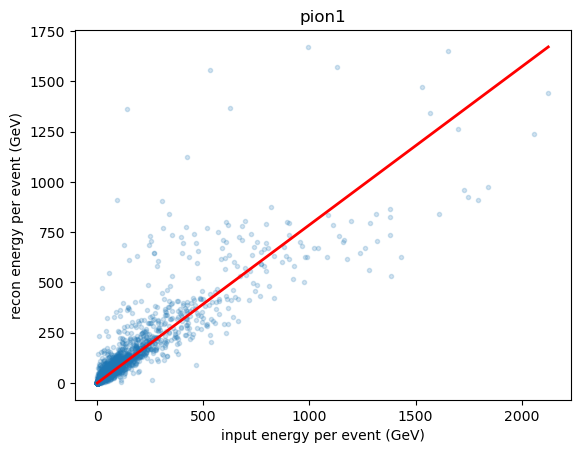

Layer  3 5  voxels


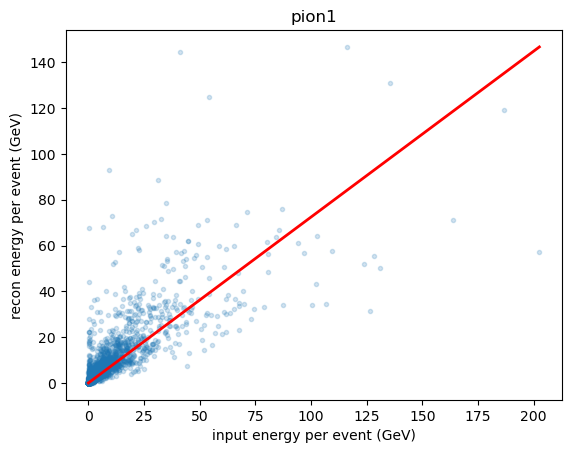

Layer  4 150  voxels


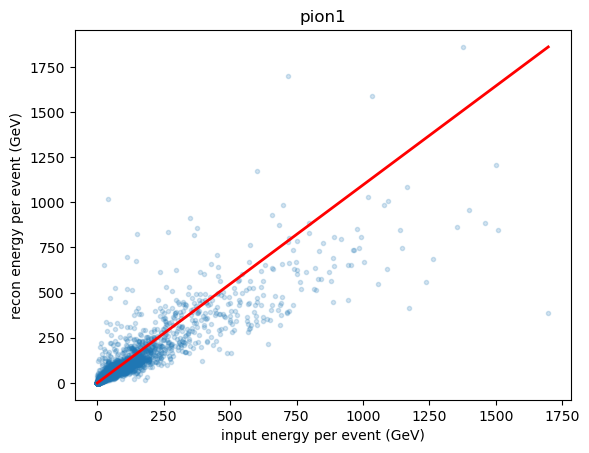

Layer  5 160  voxels


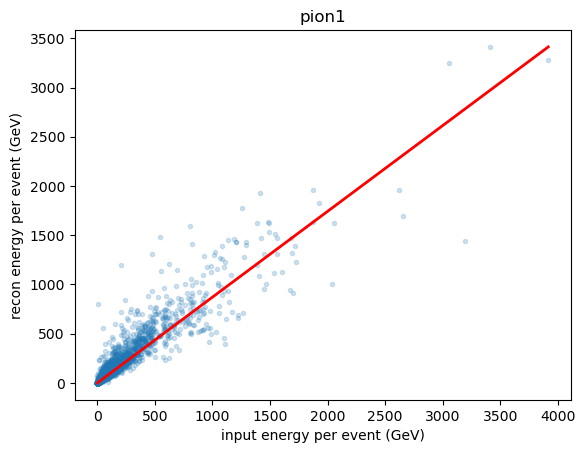

Layer  6 10  voxels


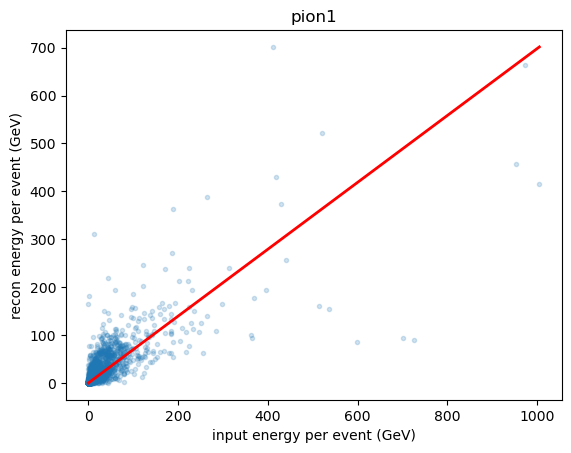

In [24]:
idxPrev = 0
for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
    l = idx - idxPrev
    print('Layer ', i, l, ' voxels')
    plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
    plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
    plt.xlabel("input energy per event (GeV)")
    plt.ylabel("recon energy per event (GeV)")
    plt.title(f'{part}')
    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
    plt.show()
    idxPrev = idx

In [25]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

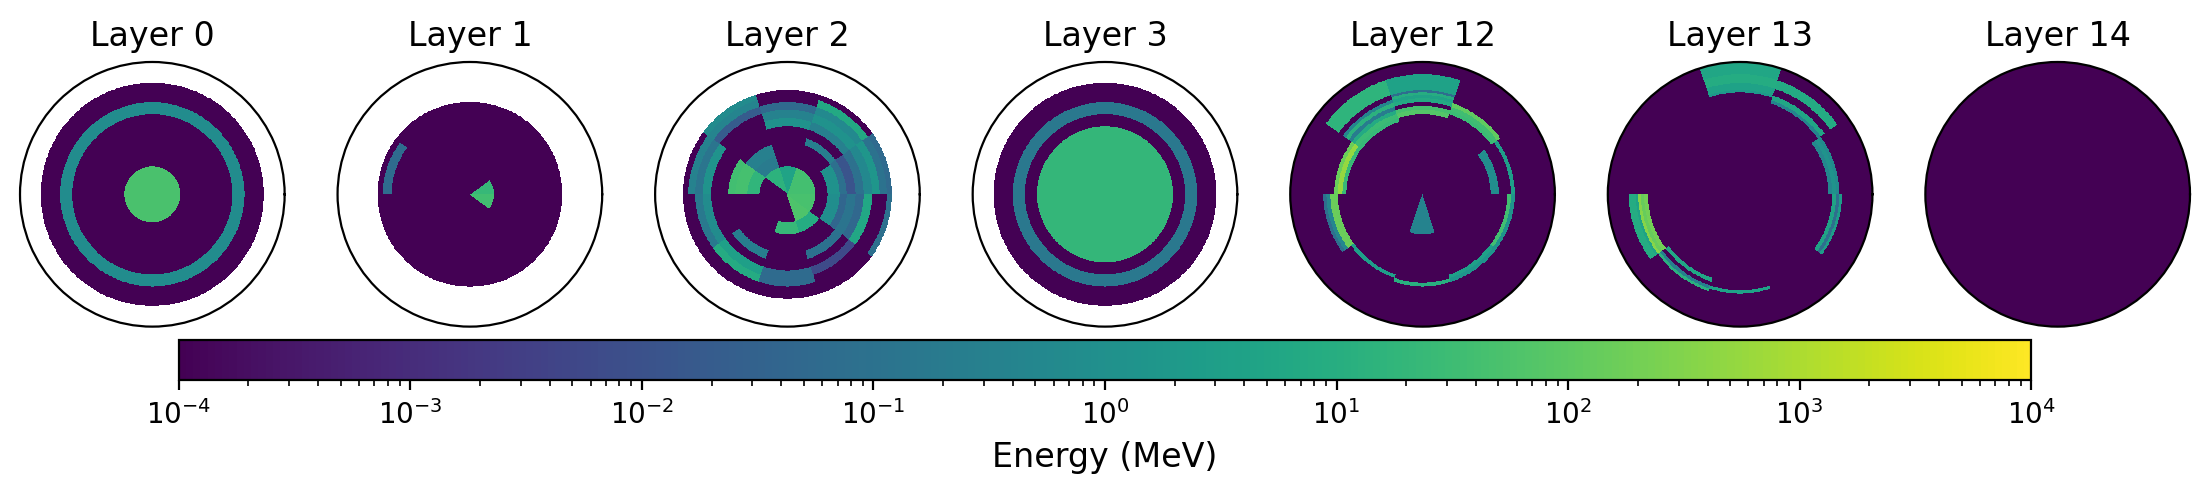

In [26]:
# HLF_1_photons.DrawSingleShower(in_data[0,:].detach().cpu().numpy(), filename=None)
HLF_1_pions.DrawSingleShower(in_data[2,:].detach().cpu().numpy(), filename=None)

In [158]:
# HLF_1_pions.relevantLayers = [0,1,2,3,4,5,6]
num_splits = 400
# layer_boundaries = np.unique(HLF_1_photons.bin_edges)
layer_boundaries = np.unique(HLF_1_pions.bin_edges)
max_r = 0
# for radii in self.r_edges:
#     if radii[-1] > max_r:
#         max_r = radii[-1]
# vmax = 1e4 #data.max() # <-------------------

In [159]:
in_data.shape[0]

1024

In [11]:
def parseToLayer(in_data):
    bs = in_data.shape[0]
    layer = {}
    layer_boundaries = np.unique(HLF_1_pions.bin_edges)
    for idx in range(len(np.unique(HLF_1_pions.bin_edges))-1):
        layer[f'{idx}'] = in_data[:, layer_boundaries[idx]:layer_boundaries[idx+1]].reshape(
                        bs, int(HLF_1_pions.num_alpha[idx]), -1)
        if idx == 0:
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 2, dim=2)
            layer[f'{idx}'] = torch.cat((layer[f'{idx}'][:, :, :4], layer[f'{idx}'][:, :, 3:4], layer[f'{idx}'][:, :, 4:8], layer[f'{idx}'][:, :, 7:8], layer[f'{idx}'][:, :, 8:12], layer[f'{idx}'][:, :, 11:12], layer[f'{idx}'][:, :, 12:16], layer[f'{idx}'][:, :, 15:16]), dim=2)
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 10, dim=1)
        elif idx in [1,2]:
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 2, dim=2)
        elif idx == 3:
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 4, dim=2)
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 10, dim=1)
        elif idx == 4:
            layer[f'{idx}'] = torch.cat((layer[f'{idx}'][:, :, :4], layer[f'{idx}'][:, :, 3:4], layer[f'{idx}'][:, :, 4:8], layer[f'{idx}'][:, :, 7:8], layer[f'{idx}'][:, :, 8:12], layer[f'{idx}'][:, :, 11:12], layer[f'{idx}'][:, :, 12:15], layer[f'{idx}'][:, :, 14:15]), dim=2)
            layer[f'{idx}'] = torch.cat((layer[f'{idx}'][:, :, :], layer[f'{idx}'][:, :, 18:19]), dim=2)
        elif idx == 5:
            layer[f'{idx}'] = torch.cat((layer[f'{idx}'][:, :, :4], layer[f'{idx}'][:, :, 3:4], layer[f'{idx}'][:, :, 4:8], layer[f'{idx}'][:, :, 7:8], layer[f'{idx}'][:, :, 8:12], layer[f'{idx}'][:, :, 11:12], layer[f'{idx}'][:, :, 12:16], layer[f'{idx}'][:, :, 15:16]), dim=2)
        elif idx == 6:
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 2, dim=2)
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 10, dim=1)
        layer[f'{idx}'] = layer[f'{idx}'].unsqueeze(1)
        print(layer[f'{idx}'].shape)
    return torch.cat([layer[f'{i}'] for i in layer.keys()], dim=1)
        
    # print(layer[f'{idx}'].shape)

In [144]:
def parseToLayer(in_data):
    bs = in_data.shape[0]
    layer = {}
    layer_boundaries = np.unique(HLF_1_photons.bin_edges)
    for idx in range(len(np.unique(HLF_1_photons.bin_edges))-1):
        layer[f'{idx}'] = in_data[:, layer_boundaries[idx]:layer_boundaries[idx+1]].reshape(
                        bs, int(HLF_1_photons.num_alpha[idx]), -1)
        if idx == 0:
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 2, dim=2)
            layer[f'{idx}'] = torch.cat((layer[f'{idx}'][:, :, :4], layer[f'{idx}'][:, :, 3:4], layer[f'{idx}'][:, :, 4:8], layer[f'{idx}'][:, :, 7:8], layer[f'{idx}'][:, :, 8:12], layer[f'{idx}'][:, :, 11:12], layer[f'{idx}'][:, :, 12:16], layer[f'{idx}'][:, :, 15:16]), dim=2)
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 10, dim=1)
        elif idx == 1:
            layer[f'{idx}'] = torch.cat((layer[f'{idx}'][:, :, :4], layer[f'{idx}'][:, :, 3:4], layer[f'{idx}'][:, :, 4:8], layer[f'{idx}'][:, :, 7:8], layer[f'{idx}'][:, :, 8:12], layer[f'{idx}'][:, :, 11:12], layer[f'{idx}'][:, :, 12:16], layer[f'{idx}'][:, :, 15:16]), dim=2)
        elif idx == 2:
            layer[f'{idx}'] = torch.cat((layer[f'{idx}'], layer[f'{idx}'][:, :, -1:]), dim=2)
        elif idx == 3:
                layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 4, dim=2)
                layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 10, dim=1)
        elif idx == 4:
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 4, dim=2)
            layer[f'{idx}'] = torch.repeat_interleave(layer[f'{idx}'], 10, dim=1)
        layer[f'{idx}'] = layer[f'{idx}'].unsqueeze(1)
        # print(layer[f'{idx}'].shape)
    return torch.cat([layer[f'{i}'] for i in layer.keys()], dim=1)
        
    # print(layer[f'{idx}'].shape)

In [12]:
# def layerTo1D(in_data):
#     bs = in_data.shape[0]
#     lim = in_data.shape[1]
#     layer = {}
#     layer_boundaries = np.unique(HLF_1_photons.bin_edges)
#     for idx in range(lim):
#         if idx == 0:
#             layer[f'{idx}'] = in_data[:,idx,0,[0,4,5,9,10,14,15,19]]
#         elif idx == 1:
#             layer[f'{idx}'] = in_data[:,idx,:,[0,1,2,3,5,6,7,8,10,11,12,13,15,16,17,18]].reshape( bs, -1)
#         if idx == 2:
#             layer[f'{idx}'] = in_data[:,idx,:,:-1].reshape( bs, -1)
#         elif idx == 3:
#             layer[f'{idx}'] = in_data[:,idx,0,[0,4,8,12,16]]
#         elif idx == 4:
#             layer[f'{idx}'] = in_data[:,idx,0,[0,4,8,12,16]]
#         print(layer[f'{idx}'].shape)
#     return torch.cat([layer[f'{i}'] for i in layer.keys()], dim=1)


def layerTo1D(in_data):
    bs = in_data.shape[0]
    lim = in_data.shape[1]
    layer = {}
    layer_boundaries = np.unique(HLF_1_pions.bin_edges)
    for idx in range(lim):
        if idx == 0:
            layer[f'{idx}'] = in_data[:,idx,0,[0,4,5,9,10,14,15,19]]
        elif idx == 1:
            layer[f'{idx}'] = in_data[:,idx,:,[0,2,4,6,8,10,12,14,16,18]].reshape( bs, -1)
        if idx == 2:
            layer[f'{idx}'] = in_data[:,idx,:,[0,2,4,6,8,10,12,14,16,18]].reshape( bs, -1)
        elif idx == 3:
            layer[f'{idx}'] = in_data[:,idx,0,[0,4,8,12,16]]
        elif idx == 4:
            layer[f'{idx}'] = in_data[:,idx,:,[0,1,2,3,5,6,7,8,10,11,12,13,15,16,17]].reshape( bs, -1)
        elif idx == 5:
            layer[f'{idx}'] = in_data[:,idx,:,[0,1,2,3,5,6,7,8,10,11,12,13,15,16,17,18]].reshape( bs, -1)
        elif idx == 6:
            layer[f'{idx}'] = in_data[:,idx,0,[0,2,4,6,8,10,12,14,16,18]]
        print(layer[f'{idx}'].shape)
    return torch.cat([layer[f'{i}'] for i in layer.keys()], dim=1)

In [28]:
in_data = engine._reduce(in_data, true_energy, R=0.04)

In [29]:

ll = parseToLayer(in_data)
# parseToLayer(in_data)

torch.Size([1024, 1, 10, 20])
torch.Size([1024, 1, 10, 20])
torch.Size([1024, 1, 10, 20])
torch.Size([1024, 1, 10, 20])
torch.Size([1024, 1, 10, 20])
torch.Size([1024, 1, 10, 20])
torch.Size([1024, 1, 10, 20])


In [30]:
# with torch.no_grad():
fwd_output = engine.model((ll, true_energy), True)

In [21]:
fwd_output.output_activations = layerTo1D(fwd_output.output_activations)
fwd_output.output_hits = layerTo1D(fwd_output.output_hits)

# a = torch.tensor([1,2,3,4,5,6,7,8])
# ll1D.shape

torch.Size([1024, 8])
torch.Size([1024, 100])
torch.Size([1024, 100])
torch.Size([1024, 5])
torch.Size([1024, 150])
torch.Size([1024, 160])
torch.Size([1024, 10])
torch.Size([1024, 8])
torch.Size([1024, 100])
torch.Size([1024, 100])
torch.Size([1024, 5])
torch.Size([1024, 150])
torch.Size([1024, 160])
torch.Size([1024, 10])


In [31]:
batch_loss_dict = engine.model.loss(ll, fwd_output, true_energy)

In [39]:
batch_loss_dict['ae_loss'].shape
batch_loss_dict["ae_loss"].sum().backward()

In [74]:
llout = seq4(seq3(seq2(seq1(ll))))

In [98]:
_layers2(_layers(llout)).shape

torch.Size([1024, 5, 10, 20])

In [103]:
ll[0,0,1,[1:3,4]]

SyntaxError: invalid syntax (<ipython-input-103-d4ee22fb2278>, line 1)

In [97]:
_layers = nn.Sequential(
                   nn.Unflatten(1, (1000, 1,1)),
    
                   nn.ConvTranspose2d(1000, 512, (2,3), 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   

                   nn.ConvTranspose2d(512, 256, (2,3), 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),

                   nn.ConvTranspose2d(256, 128, (2,3), 1, 0),
                   nn.BatchNorm2d(128),
                   nn.PReLU(128, 0.02),
                   
                                   ).to(dev)
_layers2 = nn.Sequential(
                   nn.ConvTranspose2d(128, 64, (2,3), 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(64, 0.02),

                   nn.ConvTranspose2d(64, 32, (2,3), 1, 0),
                   nn.BatchNorm2d(32),
                   nn.PReLU(32, 0.02),

                   nn.ConvTranspose2d(32, 16, (2,3), 1, 0),
                   nn.BatchNorm2d(16),
                   nn.PReLU(16, 0.02), 

                   nn.ConvTranspose2d(16, 8, (2,3), 1, 0),
                   nn.BatchNorm2d(8),
                   nn.PReLU(8, 0.02), 

                   nn.ConvTranspose2d(8, 5, (2,3), 1, 0),
                   nn.BatchNorm2d(5),
                   nn.PReLU(5, 0.02),

                   nn.ConvTranspose2d(5, 5, (2,4), 1, 0),
                   nn.BatchNorm2d(5),
                   nn.PReLU(5, 0.02),
    
                   # nn.Flatten(),
                   # nn.Linear(576,self.num_output_nodes),
                   # nn.LeakyReLU(0.02),
#                    nn.Sigmoid(),
                                   ).to(dev)

In [67]:
seq1 = nn.Sequential(    
                   nn.Conv2d(5, 16, (2,3), 1, 0),
                   nn.BatchNorm2d(16),
                   nn.PReLU(16, 0.02),
                ).to(dev)
seq2 = nn.Sequential(
                   nn.Conv2d(16, 32, (2,3), 1, 0),
                   # nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(32, 0.02),
                   nn.BatchNorm2d(32),
                ).to(dev)
        
seq3 = nn.Sequential(
                   nn.Conv2d(32, 64, (2,3), 1, 0),
                   nn.BatchNorm2d(64),
                   nn.PReLU(64, 0.02),
                ).to(dev)
        
seq4 = nn.Sequential(
                   nn.Conv2d(64, 128, (2,3), 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   
                   nn.PReLU(128, 0.02),
                   nn.BatchNorm2d(128),
                   

                   nn.Conv2d(128, 256, (2,3), 1, 0),
                   nn.BatchNorm2d(256),
                   nn.PReLU(256, 0.02),
                   

                   nn.Conv2d(256, 512, (1,2), 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512, 0.02),
                   
    
                   nn.Conv2d(512, 1000, (1,2), 1, 0),
                   nn.MaxPool2d(2,stride=2),
                   nn.BatchNorm2d(1000),
                   nn.Sigmoid(),
    
                   nn.Flatten(),
                ).to(dev)

In [64]:
data = in_data[2,:].detach().cpu().numpy()

(1, 8)


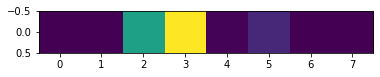

(10, 10)


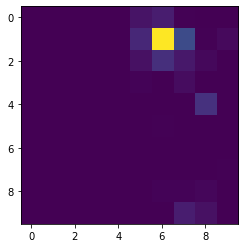

(10, 10)


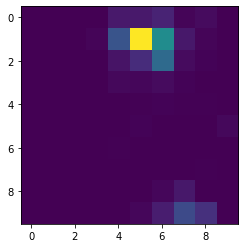

(1, 5)


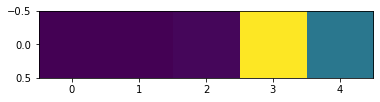

(10, 15)


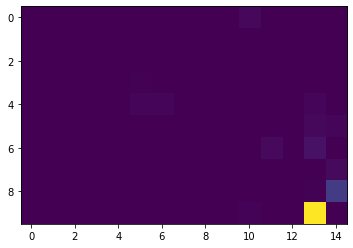

(10, 16)


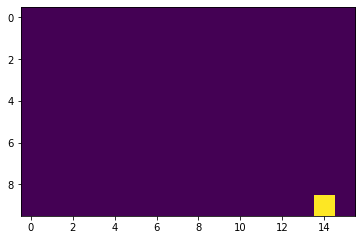

(1, 10)


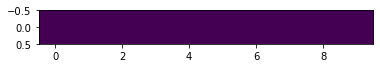

In [65]:
for idx in range(7):
    data_reshaped = data[layer_boundaries[idx]:layer_boundaries[idx+1]].reshape(
                    int(HLF_1_pions.num_alpha[idx]), -1)
    print(data_reshaped.shape)
    plt.imshow(data_reshaped)
    plt.show()

In [59]:
# HLF_1_pions.num_alpha
# data_reshaped
x.repeat_interleave(2)

array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [55]:
pts_per_angular_bin = int(num_splits / HLF_1_pions.num_alpha[idx])
data_repeated = np.repeat(data_reshaped, (pts_per_angular_bin), axis=0)

(400, 8)


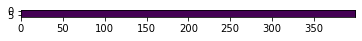

In [56]:
print(data_repeated.shape)
plt.imshow(data_repeated.T)

In [62]:
np.repeat(np.array([[1,2,3,4]]), 3)

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])

In [45]:
if self.particle == 'electron':
            figsize = (10, 20)
        else:
            figsize = (len(self.relevantLayers)*2, 3)
        fig = plt.figure(figsize=figsize, dpi=200)
        # to smoothen the angular bins (must be multiple of self.num_alpha):
        num_splits = 400
        layer_boundaries = np.unique(self.bin_edges)
        max_r = 0
        for radii in self.r_edges:
            if radii[-1] > max_r:
                max_r = radii[-1]
        vmax = 1e4 #data.max() # <-------------------
        for idx, layer in enumerate(self.relevantLayers):
            radii = np.array(self.r_edges[idx])
            if self.particle != 'electron':
                radii[1:] = np.log(radii[1:])
            theta, rad = np.meshgrid(2.*np.pi*np.arange(num_splits+1)/ num_splits, radii)
            pts_per_angular_bin = int(num_splits / self.num_alpha[idx])
            data_reshaped = data[layer_boundaries[idx]:layer_boundaries[idx+1]].reshape(
                int(self.num_alpha[idx]), -1)
            data_repeated = np.repeat(data_reshaped, (pts_per_angular_bin), axis=0)
            if self.particle == 'electron':
                ax = plt.subplot(9, 5, idx+1, polar=True)
            else:
                ax = plt.subplot(1, len(self.r_edges), idx+1, polar=True)
            ax.grid(False)
            pcm = ax.pcolormesh(theta, rad, data_repeated.T+1e-16, norm=LN(vmin=1e-4, vmax=vmax))
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            if self.particle == 'electron':
                ax.set_rmax(max_r)
            else:
                ax.set_rmax(np.log(max_r))
            ax.set_title('Layer '+str(layer))
        if self.particle == 'electron':
            axins = inset_axes(fig.get_axes()[-3], width="500%",
                               height="15%", loc='lower center', bbox_to_anchor=(0., -0.2, 1, 1),
                               bbox_transform=fig.get_axes()[-3].transAxes,
                               borderpad=0)
        else:
            wdth = str(len(self.r_edges)*100)+'%'
            axins = inset_axes(fig.get_axes()[len(self.r_edges)//2], width=wdth,
                               height="15%", loc='lower center', bbox_to_anchor=(0., -0.2, 1, 1),
                               bbox_transform=fig.get_axes()[len(self.r_edges)//2].transAxes,
                               borderpad=0)
        cbar = plt.colorbar(pcm, cax=axins, fraction=0.2, orientation="horizontal")
        cbar.set_label(r'Energy (MeV)', y=0.83, fontsize=12)

tensor([[1.0611e-01, 0.0000e+00, 6.1680e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5192e-01, 6.0363e-07, 1.4223e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.7351e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 9.2154e-02, 1.8969e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1684e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.1812e-01, 2.7697e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0')